# Mix the tunes

In [1]:
import numpy as np 
import pandas as pd
import ffmpeg
from pathlib import Path

import glob
import os
import shutil

import IPython.display as ipd
from scipy.io import wavfile
from scipy import signal

from pydub import AudioSegment
import matplotlib.pyplot as plt 
from scipy.signal import resample
from pydub.effects import speedup

### Pull all the available wavs that you can work with

In [2]:
def pull_available_wavs(source_dir, target_dir, extension):
    source_dir = os.path.expanduser(source_dir)
    target_dir = os.path.expanduser(target_dir)
    
    # Create target directory if it doesn't exist, make pattern to find wavs via glob match
    os.makedirs(target_dir, exist_ok=True)
    pattern = os.path.join(source_dir, f"*.{extension}")
    matching_files = glob.glob(pattern, recursive=False)

    # Add each file to a list
    available_wavs = [f for f in glob.glob(pattern) if os.path.isfile(f)]
    
    # Copy each file to target directory
    for file_path in matching_files:
        if os.path.isfile(file_path):
            filename = os.path.basename(file_path)
            target_path = os.path.join(target_dir, filename)
            shutil.copy2(file_path, target_path)

    return available_wavs

avail_wavs = pull_available_wavs("~/ohw25_proj_RiptideRemix/data/template_sounds", "~/ohw25_proj_RiptideRemix/contributor_folders/isabelle/audio_processing_mixers/available_wavs", "wav")

### Generate your empty waveform and add the first clip

In [3]:
sample_rate = 44100
duration = 60
empty_audio = np.zeros(int(sample_rate * duration), dtype=np.float32)

wavfile.write('my_song.wav', sample_rate, empty_audio)
print("The original empty song file is length: ", len(empty_audio))


The original empty song file is length:  2646000


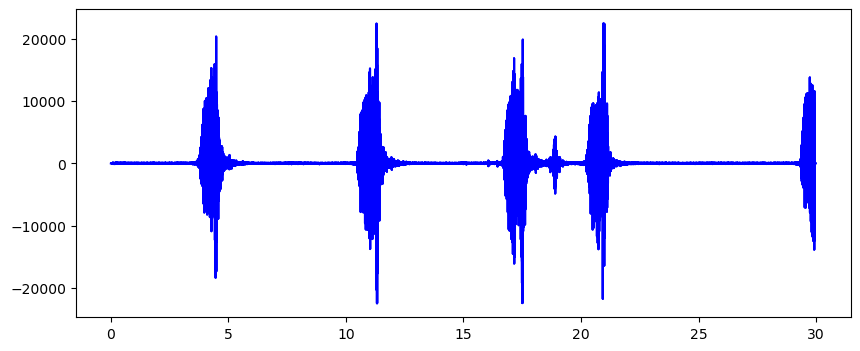

In [4]:
sr, d = wavfile.read(avail_wavs[1])
plt.figure(figsize=(10, 4))
plt.plot(np.arange(0, len(d)) / sr, d, 'b')
ipd.Audio(avail_wavs[0])

In [5]:
def process_one_clip_to_add(clip, start_time, loop_val, loud_val, ptch_spd_val, gen_sr=44100, max_len=60):
    max_len = gen_sr * max_len
    print("NEXT FILE____________________________")
    sr, d = wavfile.read(clip)
    if len(d.shape) > 1:
        d = d.mean(axis=1)
    if np.max(np.abs(d)) != 0: d = d / np.max(np.abs(d))  # Normalize the amplitudes
    
    print("The raw sampling rate and length are: ", sr, len(d))

    # Modify sampling rate to match the file we are building on
    if sr != 44100:
        ratio = 44100 / sr
        d = signal.resample(d, int(len(d) * ratio))        # Use Fourier method for better quality
        sr = 44100
    
    # Loop
    sr_looped, d_looped = loop(sr, d, loop_val)
    print("Length of looped file: ", len(d_looped))

    # Loudness
    sr_loop_amp, d_loop_amp = loud(sr_looped, d_looped, loud_val)
    
    # Pitch/Speed
    sr_loop_amp_ps, d_loop_amp_ps = pitch_speed(sr_loop_amp, d_loop_amp, ptch_spd_val)

    sr = sr_loop_amp_ps
    d = d_loop_amp_ps
    
    # Length and start time adjustment
    start_chunk_len = start_time * sr
    strt_zero_chunk = np.zeros(start_chunk_len)
    padded_d = np.concatenate((strt_zero_chunk, d))

    if len(padded_d) > 2646000: d = padded_d[:2646000]
    elif len(padded_d) < 2646000: d = np.append(padded_d, np.zeros(2646000 - len(padded_d)))
    else: d = padded_d

    return sr, d


def loop(sr, d, num_loops):
    d_looped = np.tile(d, num_loops)
    sr_looped = sr
    return sr_looped, d_looped


def loud(sr, d, loud_val):
    d_amp = d * loud_val
    sr_amp = sr
    return sr_amp, d_amp


def pitch_speed(sr, d, factor):
    num_samples = int(len(d) / factor)
    y_pitched = resample(d, num_samples)
    sr_pitched = sr
    return sr_pitched, y_pitched

In [6]:
def combine_clips(base_song, clips_to_add):
    sr_base, d_base = wavfile.read(base_song)
    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(0, len(d_base)) / sr_base, d_base, 'b')
    
    srs, ds, combined_sounds = [], [], d_base
    for index, row in clips_to_add.iterrows():        
        sr, d = process_one_clip_to_add(row['clip'], row['start_time'], row['loops'], row['loudness'], row['pitch_speed'])
        srs.append(sr)
        ds.append(d)
        plt.plot(np.arange(0, len(d)) / sr, (d-(1.5*index)), 'r')
        combined_sounds += d
    
    plt.xlabel('Time (s)'), plt.ylabel('Amplitude')
    plt.title('My Song!')
    plt.grid(True, alpha=0.3)
    
    wavfile.write('my_final_song.wav', sr_base, np.array(combined_sounds, dtype=np.float32))
    
    return

#combine_clips('my_song.wav', 
#ipd.Audio('my_final_song.wav')
#ipd.Audio(avail_wavs[3])


In [7]:
clips_to_add = pd.DataFrame(columns=['clip', 'start_time', 'loops', 'loudness', 'pitch_speed'])

In [8]:
## SELECT YOUR CLIP:
audio_selected = avail_wavs[1]
sr, d = wavfile.read(audio_selected)
d = d / np.max(np.abs(d))

## INPUTS FROM THE DASHBOARD:

start_time = 15          # 0 - 60
loops = 10               # 1 - 60
loudness = 1            # 0 - 2
ptch_spd = 0.25         # 0 - 4

clips_to_add.loc[len(clips_to_add)] = [audio_selected, start_time, loops, loudness, ptch_spd]
print(clips_to_add)
for index, clip in enumerate(clips_to_add['clip']):
    print(clip.split("temp", 1)[-1])

                                                clip  start_time  loops  \
0  /home/jovyan/ohw25_proj_RiptideRemix/data/temp...          15     10   

   loudness  pitch_speed  
0         1         0.25  
late_sounds/humpback_nonsong.wav


NEXT FILE____________________________
The raw sampling rate and length are:  44100 1321984
Length of looped file:  13219840


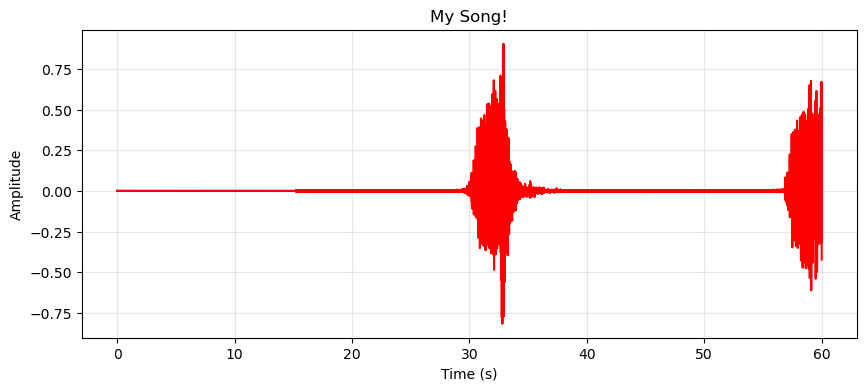

In [10]:
combine_clips('my_song.wav', clips_to_add)

In [ ]:
ipd.Audio('my_final_song.wav')